# Applied Finance Project: Global Asset Allocation

## Abstract

This project aims to build a country selection model for quantitative global tactical asset allocation and the asset class I invest in is country/region ETF. For the 41 ETFs selected, I create eight factors including volatility, 1-month drawdown, acceleration, trading volume, trading volume volatility, PCA(10-month SMA & EWMA), PCA1,2(momentum & reversal) and combine these factors using the composite score method based on factor quantiles. I update the model annually using a rolling train set of five years' data and rebalance my long-short portfolios monthly.

During the period 2015-2019, the mean variance efficient portfolio with elastic net generates the highest annual return of 17.82% and Sharpe ratio of 1.35, which are much higher than those for equal-weighted portfolio, value-weighted portfolio and MVE without elastic net portfolio. Compared to the Fama French three factors model, the monthly alphas for the MVE portfolios (with and without elastic net) are 0.86% and 1.17%, and both are statistically significant under 95 percent confidence level. The profits mainly come from the long positions while the short positions lose money because ETFs generally have stable positive returns.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime
import scipy.stats
import math
from pandas.tseries.offsets import *
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet,ElasticNetCV
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Data
The data I use are mainly from WRDS database. I mainly focus our research on countries' ETFs and use different types of momentum as factors for strategy return prediction. At this stage, I selected 41 countries and picked only one typical ETF to represent each country. The price data range from 01/2009 to 12/2019 to test the factor significance. For further backtesting, I will apply the rolling window backtest method with a window of 5 years of train set and one  following year as test set. The frequancy of the data is on daily basis. The rebalance frequency will be one month.

In [6]:
#import data
data=pd.DataFrame(pd.read_csv("AFP1129.csv"))
data['date']=data['date'].apply(lambda x:datetime.datetime.strptime(x,'%Y/%m/%d'))
data.loc[data['price']<0,'price']=[np.nan]*len(data.loc[data['price']<0,'price'])
data['facpr']=data['facpr'].fillna(0)
data.loc[(data['dailyrtn'] == 'C') | (data['dailyrtn'] == 'B') | (data['dailyrtn'] == 'A') 
             | (data['dailyrtn'] == 'D') | (data['dailyrtn'] == 'E'), 'dailyrtn'] = np.nan
data.loc[:, 'dailyrtn'] = data['dailyrtn'].astype(float)
ticker=data['ticker'].unique()
data.set_index(['date','ticker'], inplace=True)
# factorlist=["sma10m","ewma10m","high","mom1","reversal","vol","acceleration"]
factorlist=["sma10m","ewma10m","high","mom1","mom2","reversal","vol","acceleration",'tvolume','tvolumevol']
backtestfrequency=261
rebalancefrequency=21 

### Country list

In [3]:
country=pd.DataFrame(pd.read_csv("country.csv"))
country

,Ticker,Country
0,EIRL,IRELAND
1,EFNL,FINLAND
2,EWG,GERMANY
3,EWN,NETHERLANDS
4,EDEN,DENMARK
5,EWD,SWEDEN
6,EWC,CANADA
7,EWL,SWITZERLAND
8,EWO,AUSTRIA
9,EWA,AUSTRALIA


### Factor list
- sma10m: 10 month simple moving average prices
- ewma10m: exponentially weighted past 10 months' closing price.
- high: Rolling maximum drawdown of price
- mom1: 1-month SMA/6-month SMA
- mom2: cumulative return between past 6  month ans past 12 month
- reversal: past 21-day cumulative return
- vol: annualized volatility of daily returns over the past one month 
- tvolumn: trading volumn
- tvolumnvol: trading volumn volatility
- acceleration: we set the window size as 2 months. For each month within the rolling window, we ran linear regression of the price on time using least square method. Then we got the price slope for each month. The difference between the latter month and the former month is defined as the price acceleration factor.
- tvolume: daily trading volume
- tvolumevol: annualized volatilities of past 1-month trading volumes


In [7]:
#get daily return and forward return
def compute_forward_returns(df, periods, filter_zscore=None):
    df1=df.copy()
    df1['mktvalues']=df1['price']*df1['shares']
    df1['log_ret'] = df1['dailyrtn'].fillna(0)
    df1.loc[:, 'log_ret'] = np.log(1 + df1['log_ret'])

    for i in ticker:
        etf=df1.xs(key=i,level=1)
        facpr=(1+etf['facpr']).cumprod()
        etf.loc[:,'price']=etf.loc[:,'price']*facpr
        delta1 = etf.loc[:,'log_ret'].rolling(periods).sum()
        delta2 = (np.exp(delta1)-1).shift(-periods)

        if filter_zscore is not None:
            mask = abs(delta - delta.mean()) > (scipy.stats.norm.ppf(filter_zscore) * delta.std())
            delta2[mask] = np.nan
        
        df1.loc[(slice(None),i),'forwardrtn']=delta2.values.tolist()

    return df1[['price','volumn','dailyrtn','mktvalues','forwardrtn']]

#define factor
def ewma10m(etf,filter_zscore=None):
    factor=etf['price'].ewm(halflife=105, adjust=False).mean()
    factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

def high(etf,filter_zscore=None):
    factor=etf['price'].rolling(window=21).max()
    factor=etf['price']/factor
    #factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

def generate_factors(data,factor,filter_zscore=None):
    for i in ticker:
        etf=data.xs(key=i,level=1)
        
        if factor=="ewma10m":
            factordata = ewma10m(etf,filter_zscore)

        data.loc[(slice(None),i),factor]=factordata['factor'].values.tolist()
        
    return data

def mom1(etf,filter_zscore=None):
    sma1=etf['price'].rolling(window=21).mean()
    sma6=etf['price'].rolling(window=126).mean()
    factor=sma1/sma6
    factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

def mom2(etf,filter_zscore=None):
    
    factor=((etf['price'].pct_change(252)+1)/(etf['price'].pct_change(126)+1))-1
    #factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

def reversal(etf,filter_zscore=None):
    factor=etf['price'].pct_change(21)
    #factor=((etf['price'].pct_change(252)+1)/(etf['price'].pct_change(21)+1))-1
    #factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

def sma10m(etf,filter_zscore=None):
    factor=etf['price'].rolling(window=210).mean()
    factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

def vol(etf,filter_zscore=None):
    
    factor=etf['dailyrtn'].rolling(window=21).std()*math.sqrt(12)
    #factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf


def acceleration(etf,filter_zscore=None):
    
    window_length=21
    
#     def slope(y):
#         X = sm.add_constant(np.arange(window_length) )
#         model1 = sm.OLS(y[:window_length], X).fit()
#         model2 = sm.OLS(y[window_length:], X).fit()
#         slopediff = model2.params[1]-model1.params[1]
#         return slopediff
    def slope(y):
        X = np.arange(window_length)
        slopediff = (np.cov(X,y[window_length:])[0][1]-np.cov(X,y[:window_length])[0][1])/X.var()
        return slopediff
    
    factor=etf['price'].rolling(window=window_length*2).apply(slope)
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

def tvolume(etf,filter_zscore=None):
    
    factor=etf['volumn']
    factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

def tvolumevol(etf,filter_zscore=None):
    
    factor=etf['volumn'].rolling(window=21).std()*math.sqrt(12)
    factor=(factor-factor.mean())/(factor.std())  #standardize
    
    if filter_zscore is not None:
        mask = abs(factor) > scipy.stats.norm.ppf(filter_zscore)
        factor[mask] = np.nan

    etf['factor']=factor
    
    return etf

#generate factor
def generate_factors(data,factorlist,filter_zscore=None):
    
    for factor in factorlist:
        
        for i in ticker:
            etf=data.xs(key=i,level=1)

            if factor=="sma10m":
                factordata = sma10m(etf,filter_zscore)

            if factor=="ewma10m":
                factordata = ewma10m(etf,filter_zscore)

            if factor=="high":
                factordata = high(etf,filter_zscore)

            if factor=="mom1":
                factordata = mom1(etf,filter_zscore)

            if factor=="mom2":
                factordata = mom2(etf,filter_zscore)
                
            if factor=="reversal":
                factordata = reversal(etf,filter_zscore)

            if factor=="vol":
                factordata = vol(etf,filter_zscore)

            if factor=="acceleration":
                factordata = acceleration(etf,filter_zscore)
            
            if factor=="tvolume":
                factordata = tvolume(etf,filter_zscore)
                
            if factor=="tvolumevol":
                factordata = tvolumevol(etf,filter_zscore)

            data.loc[(slice(None),i),factor]=factordata['factor'].values.tolist()
            
    data=data.dropna()

    return data

#rank factor
def factor_rank(df, factorlist, quantiles=5):
    
    df2=df.dropna()
    
    def quantile_calc(x, quantiles):
        return pd.qcut(x.rank(method='first'), quantiles, labels=False,duplicates='drop') + 1
    
    for factor in factorlist:
    
        factor_quantile = df2.groupby('date')[factor].apply(quantile_calc, quantiles)
        df2[factor+'_quantile']=factor_quantile.values.tolist()

    return df2

#define rolling model function, kind ='train' or 'test'
def rolling_model(model_date, window, kind):
    if kind=='train':
        end= model_date
#         start=model_date-BDay(window)
        start=datetime.datetime.strptime('2009-10-30',"%Y-%m-%d")+BDay(0)
    else:
        start= model_date+BDay(1)
        end=start+BDay(window)
    return start,end

def gen_modeldate(start,window):
    
    model_date_all=[datetime.datetime.strptime(start,"%Y-%m-%d")+BDay(0)]
    while 1:
        model_date_all.append(model_date_all[-1]+BDay(window))
        if model_date_all[-1]>datetime.datetime.strptime('2019-12-31',"%Y-%m-%d"):
            break
    model_date_all=model_date_all[:-2]
    return model_date_all

def rolling_dicision(df,factor,start,end,type):
    df1=df[start:end]
    quantile_ret=df1.groupby(factor+'_quantile')[['forwardrtn']].mean()
    if type=='longs':
        return quantile_ret[quantile_ret['forwardrtn']==float(quantile_ret.max())].index[0]
    else:
        return quantile_ret[quantile_ret['forwardrtn']==float(quantile_ret.min())].index[0]


def combine_factor(data,factorlist,deci_window=261,startdate='2014-12-30'):
    df=data.copy()
    model_date_all=gen_modeldate(startdate,deci_window)
    df['pscore'] = np.nan
    long_short_quantiles=pd.DataFrame(columns = ['date','factor','longs','shorts'])
    
    for i in model_date_all:
        train_start=rolling_model(model_date=i, window=deci_window*5, kind='train')[0]
        train_end=rolling_model(model_date=i, window=deci_window*5, kind='train')[1]
        test_start=rolling_model(model_date=i, window=deci_window, kind='test')[0]
        test_end=rolling_model(model_date=i, window=deci_window, kind='test')[1]
        df.loc[test_start:test_end,'pscore']=0
        
        for factor in factorlist:
            #quantile_ret.plot(kind='bar', legend=True)        
            #get long/short quantiles
            longs=rolling_dicision(df,factor,train_start,train_end,'longs')
            shorts=rolling_dicision(df,factor,train_start,train_end,'shorts')
            long_short_quantiles=long_short_quantiles.append({'date':i, 'factor':factor,'longs':longs,'shorts':shorts},ignore_index = True)
            
            #calculate pscore
            check_best = (df[test_start:test_end][factor+'_quantile'] == longs)
            check_worst = (df[test_start:test_end][factor+'_quantile'] == shorts)
            df.loc[test_start:test_end,'pscore'].loc[check_best] += 1
            df.loc[test_start:test_end,'pscore'].loc[check_worst] -= 1
            
    return df, long_short_quantiles

def pscore_decision(data,lower_threshold=-3,upper_threshold=3):
    df=data.copy()
    df['longs'] = np.where(df['pscore']>=upper_threshold,True,False)
    df['shorts'] = np.where(df['pscore']<=lower_threshold,True,False)
    df['returns_short'] = np.where(df["shorts"]==True, df["forwardrtn"]*(-1), np.nan)
    df['returns_long'] = np.where(df["longs"]==True, df["forwardrtn"] , np.nan)
    df['returns'] = np.where(df["longs"]==df["shorts"],np.nan,df.fillna(0)["returns_long"]+df.fillna(0)["returns_short"])
    
    return df

#filter selected etf
def portfolio_constituent(data):
    df=data.loc[data['returns'].notnull()]
    return df

#backfill pscroe
def backfill(data,start,end):
    df1=data.copy()
    df1.loc[start:end,'pscore']=0
    long_short_quantiles1=long_short_quantiles[long_short_quantiles['date']==end]
    
    for j in range(len(factorlist)):
        check_best = (df1[start:end][factorlist[j]+'_quantile'] == long_short_quantiles1.iloc[j,2])
        check_worst = (df1[start:end][factorlist[j]+'_quantile'] == long_short_quantiles1.iloc[j,3])
        df1.loc[start:end,'pscore'].loc[check_best] += 1
        df1.loc[start:end,'pscore'].loc[check_worst] -= 1
        
    return df1


#equal weighted portforlio
def ew_portfolio(data,deci_window=261,startdate='2014-12-30'):
    df_daily_returns = data.loc[:,['returns_short','returns_long','returns']].groupby(level=0).mean()
    df_monthly_returns = df_daily_returns.iloc[list(range(0, len(df_daily_returns), 21)),]
    df_monthly_returns.loc[:,'returns_long']=df_monthly_returns.loc[:,'returns_long'].fillna(0)
    df_monthly_returns.loc[:,'returns_short']=df_monthly_returns.loc[:,'returns_short'].fillna(0)
    df_monthly_returns.loc[:,'cum_returns'] = (1+df_monthly_returns['returns']).cumprod()
    df_monthly_returns.loc[:,'cum_returns_long'] = (1+df_monthly_returns['returns_long']*np.where(df_monthly_returns['returns_short']==0,1,0.5)).cumprod()
    df_monthly_returns.loc[:,'cum_returns_short'] = (1+df_monthly_returns['returns_short']*np.where(df_monthly_returns['returns_long']==0,1,0.5)).cumprod()
    
    return df_monthly_returns

#value weighted portforlio
def vw_portfolio(data,deci_window=261,startdate='2014-12-30'):
    df_daily_returns=pd.DataFrame()
    df_daily_returns['returns']=data.groupby(level=0).apply(lambda x: np.ma.average(x.returns, weights=x.mktvalues))
    df=data[data['returns_long'].notnull()]
    df_daily_returns['returns_long']=df.groupby(level=0).apply(lambda x: np.ma.average(x.returns_long, weights=x.mktvalues))
    df=data[data['returns_short'].notnull()]
    df_daily_returns['returns_short']=df.groupby(level=0).apply(lambda x: np.ma.average(x.returns_short, weights=x.mktvalues))
    df_monthly_returns = df_daily_returns.iloc[list(range(13, len(df_daily_returns), 21)),]

    df_monthly_returns.loc[:,'returns_long']=df_monthly_returns.loc[:,'returns_long'].fillna(0)
    df_monthly_returns.loc[:,'returns_short']=df_monthly_returns.loc[:,'returns_short'].fillna(0)
    df_monthly_returns.loc[:,'cum_returns'] = (1+df_monthly_returns['returns']).cumprod()
    df_monthly_returns.loc[:,'cum_returns_long'] = (1+df_monthly_returns['returns_long']*np.where(df_monthly_returns['returns_short']==0,1,0.5)).cumprod()
    df_monthly_returns.loc[:,'cum_returns_short'] = (1+df_monthly_returns['returns_short']*np.where(df_monthly_returns['returns_long']==0,1,0.5)).cumprod()
    
    return df_monthly_returns



#plot performance
def plot_portfolio_return(port_monthly_returns,type='cumulative'):
    port_monthly_returns['cum_returns'].plot()
    if type=='all':
        port_monthly_returns['cum_returns_long'].plot()
        port_monthly_returns['cum_returns_short'].plot()
    plt.legend(loc='best')
    
#backfill
def backfill(data,start,end):
    df1=data.copy()
    df1.loc[start:end,'pscore']=0
    long_short_quantiles1=long_short_quantiles[long_short_quantiles['date']==end]
    
    for j in range(len(factorlist)):
        check_best = (df1[start:end][factorlist[j]+'_quantile'] == long_short_quantiles1.iloc[j,2])
        check_worst = (df1[start:end][factorlist[j]+'_quantile'] == long_short_quantiles1.iloc[j,3])
        df1.loc[start:end,'pscore'].loc[check_best] += 1
        df1.loc[start:end,'pscore'].loc[check_worst] -= 1
        
    return df1

#mve portfolio
def mve(data, factorlist, startdate='2014-12-30', deci_window=261):
    df=data.copy()
    model_date_all=gen_modeldate(startdate,deci_window)
    mve_port_monthly_returns =pd.DataFrame()
    n_factor=len(factorlist)
    mve_port_monthly_returns =pd.Series()
    
    
    for k in model_date_all:
        train_start=rolling_model(model_date=k, window=deci_window*5, kind='train')[0]
        train_end=rolling_model(model_date=k, window=deci_window*5, kind='train')[1]
        test_start=rolling_model(model_date=k, window=deci_window, kind='test')[0]
        test_end=rolling_model(model_date=k, window=deci_window, kind='test')[1]
        
        data4=backfill(df,train_start,train_end)
        data4=pscore_decision(data4,lower_threshold=-4,upper_threshold=3)
        data4=portfolio_constituent(data4)
        data4=data4.loc[train_start:test_end,['forwardrtn']+factorlist]
        date=sorted(set([i[0] for i in data4.index.tolist()]))
        
        for m in factorlist:
            for n in date:
                factormean=data4.loc[n,m].mean()
                data4.loc[n,m]=(data4.loc[n,m].values-data4.loc[n,m].mean())/data4.loc[n,m].std()
        data4=data4.reset_index(drop=False)
        
        date=data4['date'].unique()
        factor_matrix =pd.DataFrame()
        for i in date:
                factor_matrix[i]=(data4.loc[data4['date']==i].iloc[:,-n_factor:]).T.dot(data4.loc[data4['date']==i].iloc[:,2])
        factor_matrix=np.transpose(factor_matrix)
        
        train_set=factor_matrix[train_start:train_end]
        factor_avg_ret=train_set.mean()
        factor_std=train_set.std()
        factor_sharpe=factor_avg_ret/factor_std
        factor_var=train_set.cov()
        X = sm.add_constant(factor_var)
        sm1 = sm.OLS(factor_avg_ret, X).fit()
        b_vector= sm1.params[1:]
        print(b_vector)
        oos_ret=factor_matrix[test_start:test_end].dot(b_vector)
        oos_ret_mean=oos_ret.mean()
        oos_ret_sd=oos_ret.std()
        sharpe=oos_ret_mean/oos_ret_sd
        
        mve_port_monthly_returns=mve_port_monthly_returns.append(oos_ret)
        
    mve=pd.DataFrame({'returns':mve_port_monthly_returns})
    return mve

#mve with elastic net
def mve_elasicnet(data, factorlist, startdate='2014-12-30', deci_window=261):
    df=data.copy()
    model_date_all=gen_modeldate(startdate,deci_window)
    mve_port_monthly_returns =pd.DataFrame()
    n_factor=len(factorlist)
    mve_port_monthly_returns =pd.Series()

    
    for k in model_date_all:
        train_start=rolling_model(model_date=k, window=deci_window*5, kind='train')[0]
        train_end=rolling_model(model_date=k, window=deci_window*5, kind='train')[1]
        test_start=rolling_model(model_date=k, window=deci_window, kind='test')[0]
        test_end=rolling_model(model_date=k, window=deci_window, kind='test')[1]
        
        data4=backfill(df,train_start,train_end)
        data4=pscore_decision(data4,lower_threshold=-4,upper_threshold=3)
        data4=portfolio_constituent(data4)
        data4=data4.loc[train_start:test_end,['forwardrtn']+factorlist]
        date=sorted(set([i[0] for i in data4.index.tolist()]))

        for m in factorlist:
            for n in date:
                data4.loc[n,m]=data4.loc[n,m].values-data4.loc[n,m].mean()
        data4 = data4.reset_index(drop=False)
        
        date=data4['date'].unique()
        factor_matrix = pd.DataFrame()
        for i in date:
            factor_matrix[i]=(data4.loc[data4['date']==i].iloc[:,-n_factor:]).T.dot(data4.loc[data4['date']==i].iloc[:,2])
        factor_matrix=np.transpose(factor_matrix)

        train_set=factor_matrix.loc[train_start:train_end,]
        test_set=factor_matrix.loc[test_start:test_end,]
        x = train_set.cov().values
        y = train_set.mean().values
        x = sm.add_constant(x) # adding a constant

        regr = ElasticNetCV(cv=5, n_alphas=100, l1_ratio=0.5).fit(x,y)
        opt_alpha = regr.alpha_
        
        model = ElasticNet(alpha = opt_alpha, l1_ratio=0.5).fit(x,y)
        b_vector= model.coef_[1:]
        print(b_vector)

        oos_ret=test_set.dot(b_vector)
        oos_ret_mean=oos_ret.mean()
        oos_ret_sd=oos_ret.std()
        sharpe=oos_ret_mean/oos_ret_sd

        mve_port_monthly_returns=mve_port_monthly_returns.append(oos_ret)
        
    mve=pd.DataFrame({'returns':mve_port_monthly_returns})
    return mve

def to_percent(temp, position):
    return '%.2f'%(100*temp) + '%'

In [8]:
data0=compute_forward_returns(data, periods=rebalancefrequency, filter_zscore=None)
data0=generate_factors(data0,factorlist,filter_zscore=None)     
data0.head()

price   volumn  dailyrtn  mktvalues  forwardrtn    sma10m  \
date       ticker                                                              
2010-01-04 EWA     23.72  4967500  0.038529  2500088.0   -0.094012 -1.912258   
           EWO     20.20   379100  0.032720   155540.0   -0.039110 -0.296272   
           EWK     13.22   329400  0.036050    63456.0   -0.025718 -1.579978   
           EWC     26.92  3007400  0.022408  3071572.0   -0.067980 -2.302671   
           EWQ     26.77    97300  0.035590   348010.0   -0.079569 -1.020113   

                    ewma10m      high      mom1      mom2  reversal       vol  \
date       ticker                                                               
2010-01-04 EWA    -1.207450  1.000000  0.849663  0.138418 -0.006700  0.048554   
           EWO    -0.241131  0.932595 -0.073446  0.160741 -0.084316  0.050320   
           EWK    -1.234063  0.970631  0.634868  0.109635 -0.035036  0.044030   
           EWC    -1.495627  1.000000  0.758004  0.166107  0.006731  0.043348   
           EWQ    -0.756386  1.000000  0.664535 -0.058796  0.007907  0.042132   

                   acceleration   tvolume  tvolumevol  
date       ticker                                      
2010-01-04 EWA        -0.068641  1.077389    0.685247  
           EWO        -0.138264  1.313512    1.879732  
           EWK        -0.068487  0.390323   -0.405988  
           EWC        -0.043576  0.436918   -0.341607  
           EWQ        -0.043704 -0.789221   -0.716120

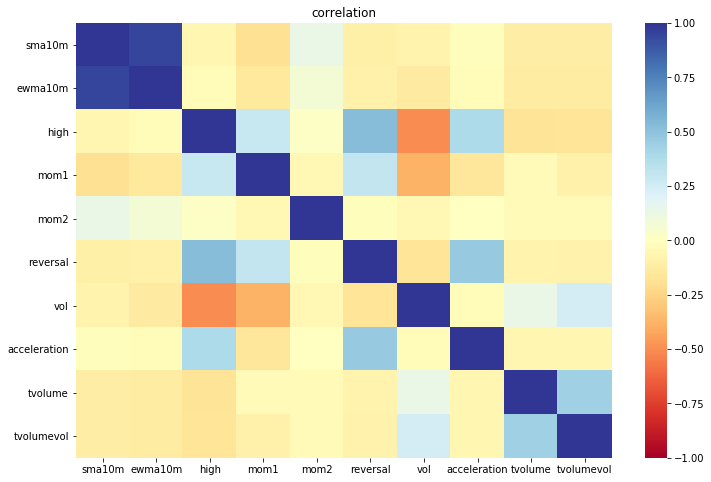

In [10]:
sns.heatmap(data0.iloc[:,5:16].corr(),vmax=1, vmin=-1,cmap='RdYlBu')
plt.title("correlation")
plt.rcParams['figure.figsize'] = (12.0,8.0)
plt.show()

### First step dimension reduction: PCA
I applied PCA for the first step dimension reduction based on the correlation map since some factors are highly correlated. sma10m and ewma10m are transformed into one principle. Momentum factors including mom1, mom2 and reversal are transformed into 2 principles.

In [11]:
#PCA attempt
def pca_ma(data):
    df=data.copy()
    sma_ewma = df.iloc[:,5:7]
    pca = PCA()
    sma_ewma_pca = pd.DataFrame(pca.fit_transform(sma_ewma),columns=['pca1', 'pca2'])
    print(pca.explained_variance_ratio_)
    df['sma_ewma_pca1']=sma_ewma_pca.iloc[:,0].to_list()
    return df

def pca_mom(data):
    df=data.copy()
    mom1_mom2_reversal = df.iloc[:,8:11]
    pca = PCA()
    mom1_mom2_reversal_pca = pd.DataFrame(pca.fit_transform(mom1_mom2_reversal),columns=['pca1', 'pca2', 'pca3'])
    print(pca.explained_variance_ratio_)
    df['mom1_mom2_reversal_pca1']=mom1_mom2_reversal_pca.iloc[:,0].to_list()
    df['mom1_mom2_reversal_pca2']=mom1_mom2_reversal_pca.iloc[:,1].to_list()
    return df


In [12]:
data0=pca_ma(data0)
data0=pca_mom(data0)

[0.97588496 0.02411504]
[0.93299927 0.05927579 0.00772495]


In [13]:
#update factorlist with substitution of pricipal analysis
factorlist=["high","vol","acceleration",'tvolume','tvolumevol','sma_ewma_pca1','mom1_mom2_reversal_pca1','mom1_mom2_reversal_pca2']

In [14]:
data0=factor_rank(data0, factorlist, quantiles=5)
data0.head()

price   volumn  dailyrtn  mktvalues  forwardrtn    sma10m  \
date       ticker                                                              
2010-01-04 EWA     23.72  4967500  0.038529  2500088.0   -0.094012 -1.912258   
           EWO     20.20   379100  0.032720   155540.0   -0.039110 -0.296272   
           EWK     13.22   329400  0.036050    63456.0   -0.025718 -1.579978   
           EWC     26.92  3007400  0.022408  3071572.0   -0.067980 -2.302671   
           EWQ     26.77    97300  0.035590   348010.0   -0.079569 -1.020113   

                    ewma10m      high      mom1      mom2  ...  \
date       ticker                                          ...   
2010-01-04 EWA    -1.207450  1.000000  0.849663  0.138418  ...   
           EWO    -0.241131  0.932595 -0.073446  0.160741  ...   
           EWK    -1.234063  0.970631  0.634868  0.109635  ...   
           EWC    -1.495627  1.000000  0.758004  0.166107  ...   
           EWQ    -0.756386  1.000000  0.664535 -0.058796  ...   

                   mom1_mom2_reversal_pca1  mom1_mom2_reversal_pca2  \
date       ticker                                                     
2010-01-04 EWA                    0.922363                 0.105160   
           EWO                   -0.002837                 0.116857   
           EWK                    0.707167                 0.073903   
           EWC                    0.830831                 0.131799   
           EWQ                    0.740028                -0.094162   

                   high_quantile  vol_quantile  acceleration_quantile  \
date       ticker                                                       
2010-01-04 EWA               3.0           4.0                    2.0   
           EWO               1.0           5.0                    1.0   
           EWK               1.0           3.0                    2.0   
           EWC               3.0           3.0                    4.0   
           EWQ               3.0           3.0                    4.0   

                   tvolume_quantile  tvolumevol_quantile  \
date       ticker                                          
2010-01-04 EWA                  5.0                  5.0   
           EWO                  5.0                  5.0   
           EWK                  4.0                  2.0   
           EWC                  4.0                  3.0   
           EWQ                  1.0                  2.0   

                   sma_ewma_pca1_quantile  mom1_mom2_reversal_pca1_quantile  \
date       ticker                                                             
2010-01-04 EWA                        2.0                               4.0   
           EWO                        5.0                               1.0   
           EWK                        2.0                               3.0   
           EWC                        1.0                               4.0   
           EWQ                        4.0                               3.0   

                   mom1_mom2_reversal_pca2_quantile  
date       ticker                                    
2010-01-04 EWA                                  3.0  
           EWO                                  3.0  
           EWK                                  2.0  
           EWC                                  3.0  
           EWQ                                  1.0  

[5 rows x 26 columns]

### Factor Ranking
My basic methodology is to use factor rank analysis for each single factor by ranking the ETFs and divide them into different quantiles. With empirical evidence, I apply long short strategy on the quantiles to generate superior returns. I plan to apply the factor rank analysis on more characteristics as suggested in the data section and discover profitbable opportunities. 

               forwardrtn
high_quantile            
1                0.004386
2                0.004041
3                0.004852
4                0.003284
5                0.003675
              forwardrtn
vol_quantile            
1               0.006046
2               0.005224
3               0.003280
4               0.003364
5               0.002177
                       forwardrtn
acceleration_quantile            
1                        0.005058
2                        0.004236
3                        0.004299
4                        0.004472
5                        0.002153
                  forwardrtn
tvolume_quantile            
1                   0.001738
2                   0.003134
3                   0.005415
4                   0.005099
5                   0.005107
                     forwardrtn
tvolumevol_quantile            
1                      0.003788
2                      0.001188
3                      0.005447
4                      0.005454
5         

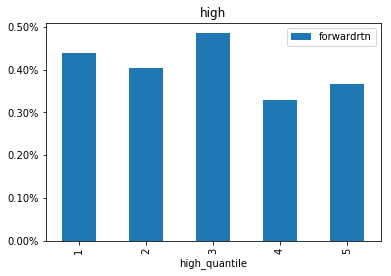

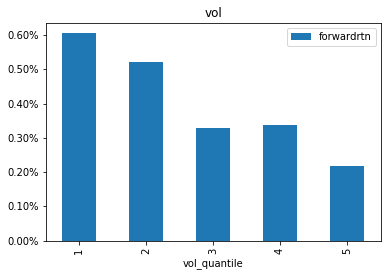

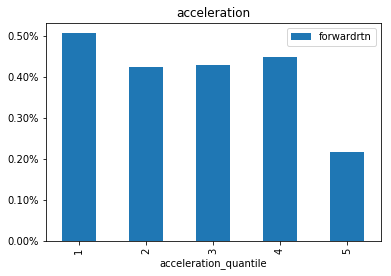

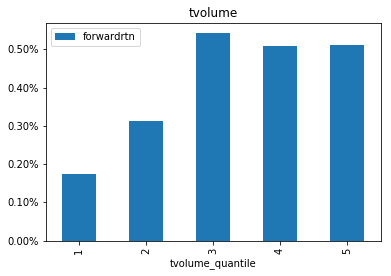

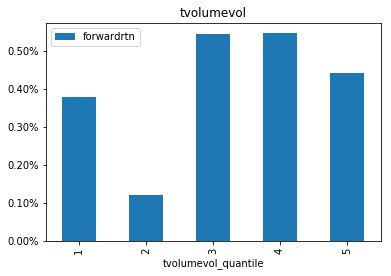

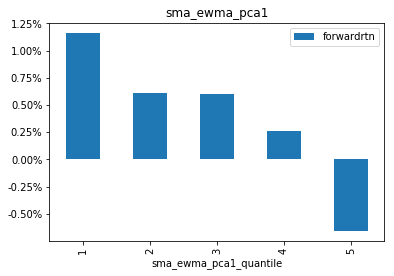

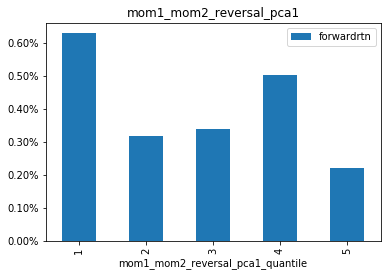

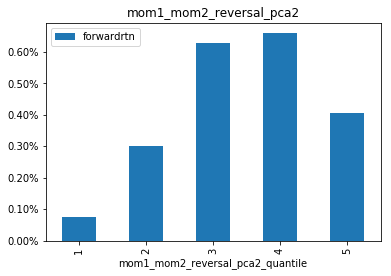

In [15]:
data0=factor_rank(data0, factorlist, quantiles=5)  
#take the first trainset as example
start= '2010-01-04'
end= '2014-12-31'

df2=data0[start:end].dropna()
plt.rcParams['figure.figsize'] = (6.0,4.0)
for factor in factorlist:
    df2.groupby(factor+'_quantile')[['forwardrtn']].mean().plot(kind='bar', legend=True,title=factor)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    print(df2.groupby(factor+'_quantile')[['forwardrtn']].mean())

### Combine Factors by Piotroski  Scoring
In each training window, for each etf and each factor, if the etf is in the quantiles generating superior returns,  score plus 1. If the etf is in the quantiles generating lowest returns,  score minus 1. Finanly, for each day, the etfs with Score over 3 are selected in to long decision group. The etfs with Score below -4 are selected in to short decision group.

In [235]:
#rolling train
data1,long_short_quantiles =combine_factor(data0,factorlist,deci_window=261,startdate='2014-12-30')

#make dicisions
data1=pscore_decision(data1,lower_threshold=-4,upper_threshold=3)
data1.head()
data2=portfolio_constituent(data1)

### Equal-weighted portfolio

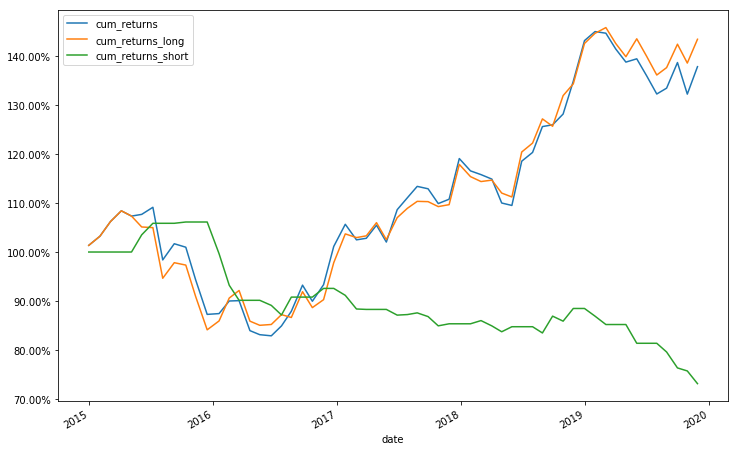

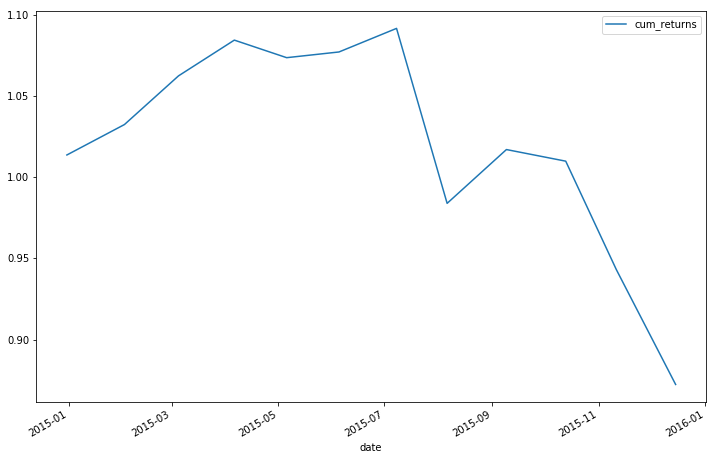

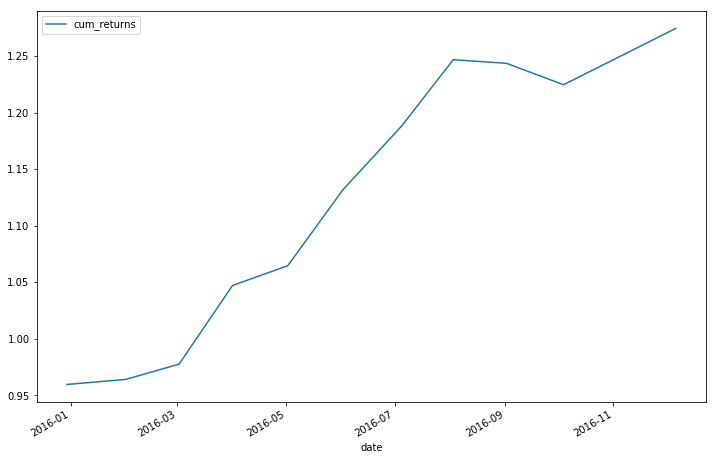

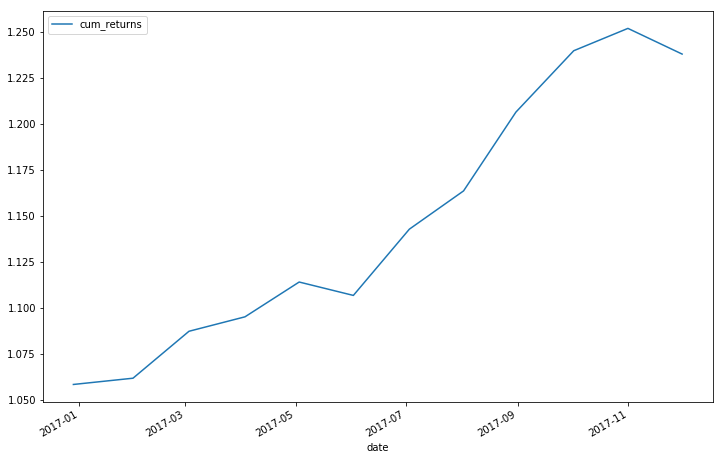

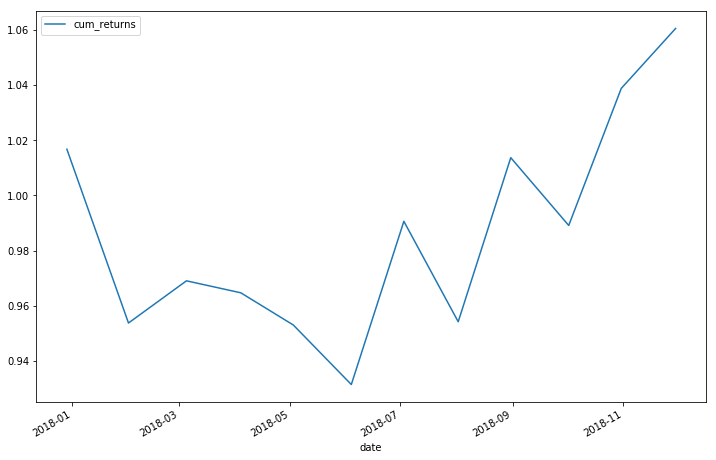

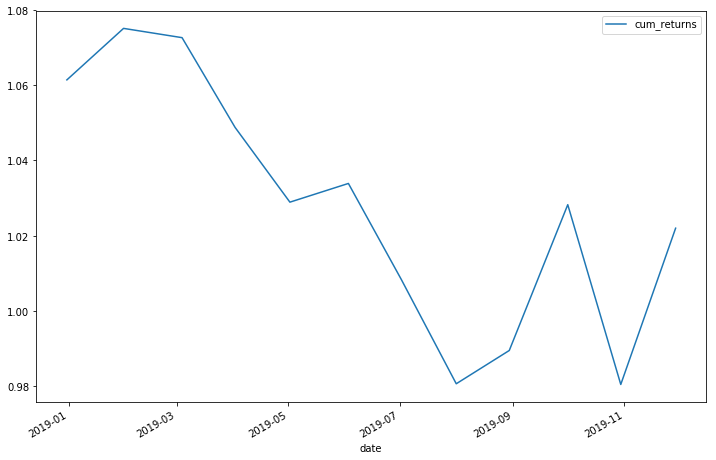

In [270]:
#equalweighted portfolio
ew_port_monthly_returns = ew_portfolio(data2,deci_window=261,startdate='2014-12-30')
#overall performance
plt.figure(0)
plt.rcParams['figure.figsize'] = (12.0,8.0)
plot_portfolio_return(ew_port_monthly_returns,type='all')
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

#periodic performance
for i in range(len(gen_modeldate(start='2014-12-30',window=261))):
    plt.figure(i+1)
    try:
        data_test=data2[gen_modeldate(start='2014-12-30',window=261)[i]:gen_modeldate(start='2014-12-30',window=261)[i+1]]
        ew_port_monthly_returns_test = ew_portfolio(data_test,deci_window=261,startdate='2014-12-30')
        plot_portfolio_return(ew_port_monthly_returns_test)    
    except:
        data_test=data2[gen_modeldate(start='2014-12-30',window=261)[i]:]
        ew_port_monthly_returns_test = ew_portfolio(data_test,deci_window=261,startdate='2014-12-30')
        plot_portfolio_return(ew_port_monthly_returns_test)    

### Value-weighted portfolio

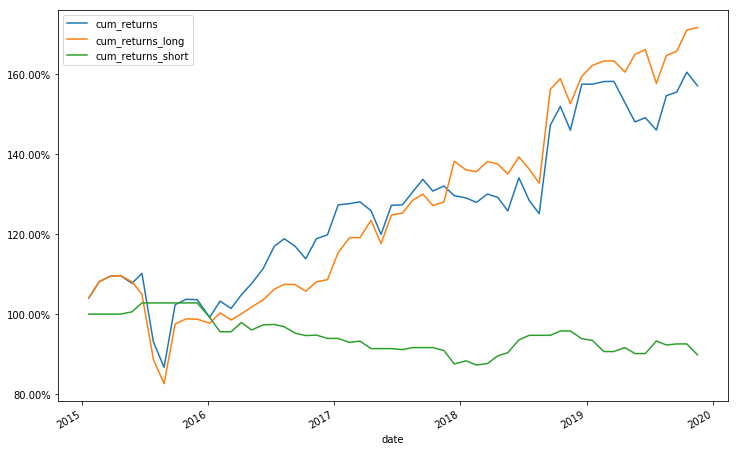

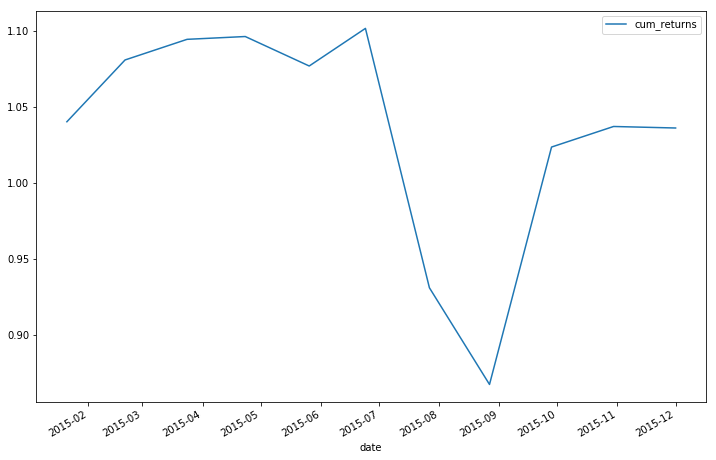

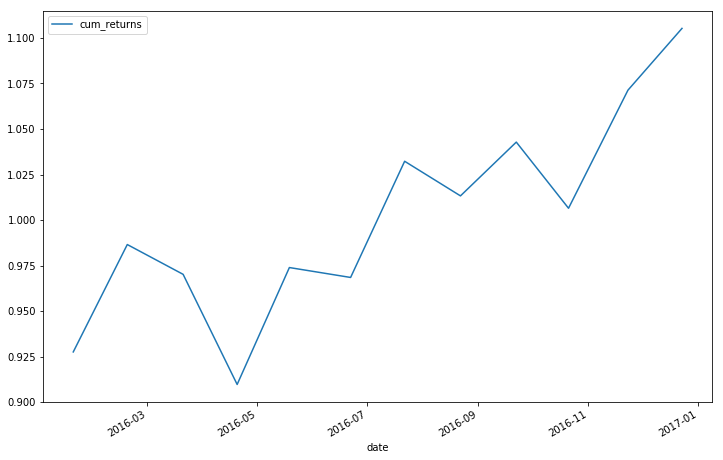

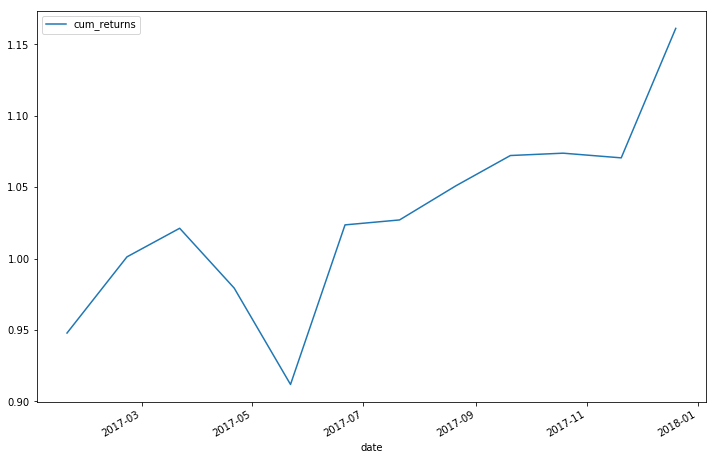

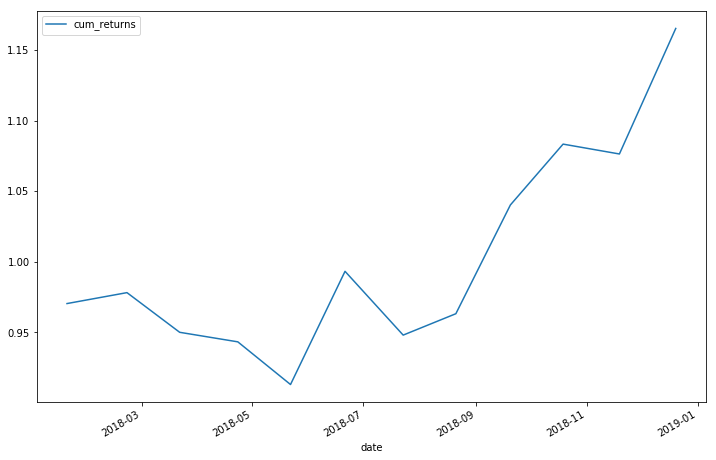

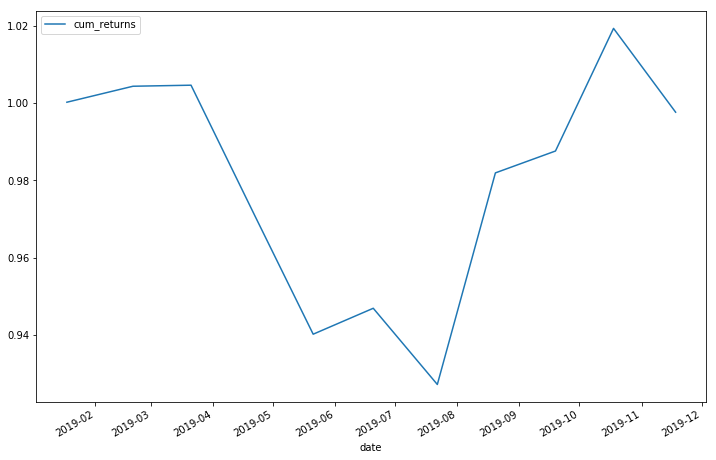

In [268]:
#valueweighted portfolio
vw_port_monthly_returns = vw_portfolio(data2,deci_window=261,startdate='2014-12-30')
#overall performance
plt.figure(0)
plt.rcParams['figure.figsize'] = (12.0,8.0)
plot_portfolio_return(vw_port_monthly_returns,type='all')
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))


#periodic performance
for i in range(len(gen_modeldate(start='2014-12-30',window=261))):
    plt.figure(i+1)
    try:
        data_test=data2[gen_modeldate(start='2014-12-30',window=261)[i]:gen_modeldate(start='2014-12-30',window=261)[i+1]]
        vw_port_monthly_returns_test = vw_portfolio(data_test,deci_window=261,startdate='2014-12-30')
        plot_portfolio_return(vw_port_monthly_returns_test)    
    except:
        data_test=data2[gen_modeldate(start='2014-12-30',window=261)[i]:]
        vw_port_monthly_returns_test = vw_portfolio(data_test,deci_window=261,startdate='2014-12-30')
        plot_portfolio_return(vw_port_monthly_returns_test)    

### Mean Variance efficient portforlio 

high                      -0.392116
vol                        0.511722
acceleration               0.463558
tvolumn                    0.332710
tvolumnvol                 1.143441
sma_ewma_pca1             -3.912807
mom1_mom2_reversal_pca1    0.072746
mom1_mom2_reversal_pca2    0.712263
dtype: float64
high                       0.539329
vol                        0.769125
acceleration               0.742654
tvolumn                    0.228458
tvolumnvol                 1.506913
sma_ewma_pca1             -3.497993
mom1_mom2_reversal_pca1   -0.822133
mom1_mom2_reversal_pca2    1.093061
dtype: float64
high                      -0.202192
vol                        0.747768
acceleration               0.409949
tvolumn                    1.559874
tvolumnvol                 0.450643
sma_ewma_pca1             -3.232692
mom1_mom2_reversal_pca1   -0.385036
mom1_mom2_reversal_pca2    0.635746
dtype: float64
high                      -0.254235
vol                        0.691908
acceleration       

<Figure size 864x576 with 0 Axes>

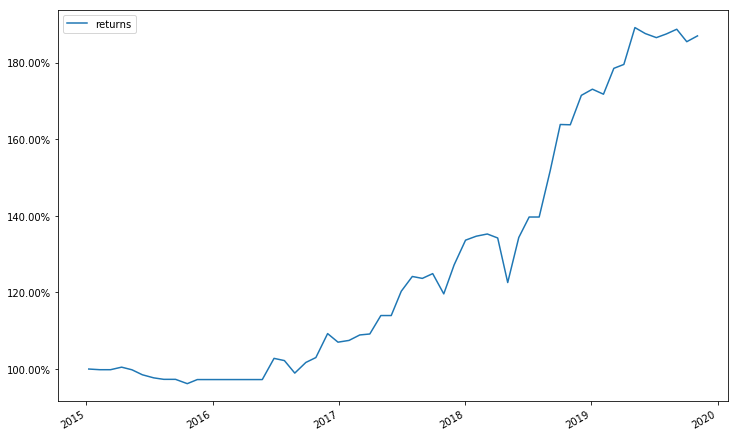

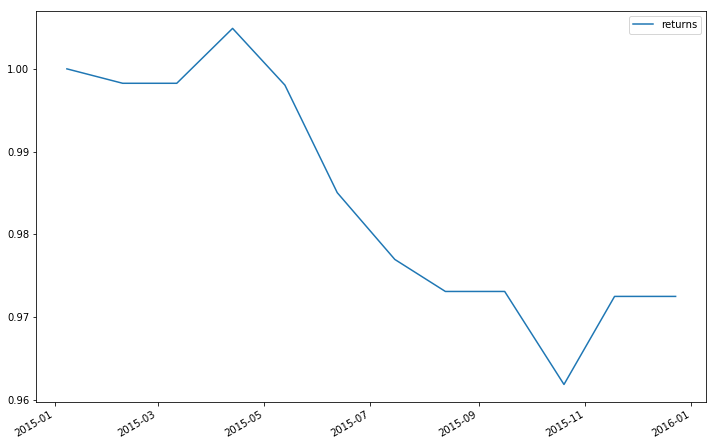

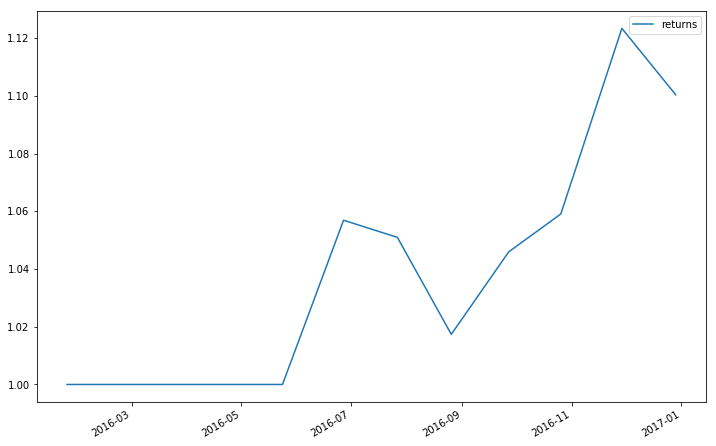

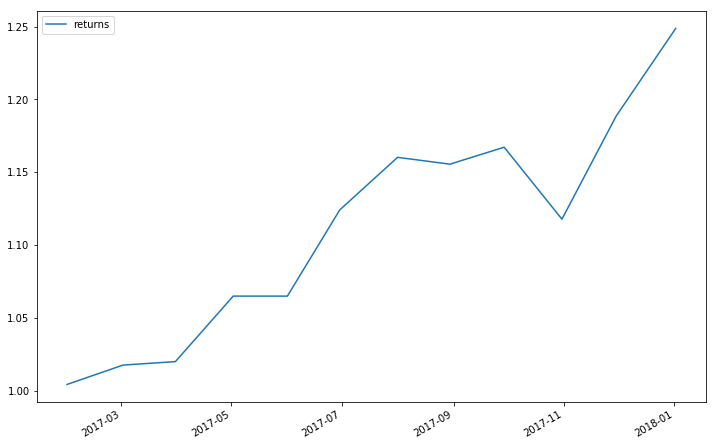

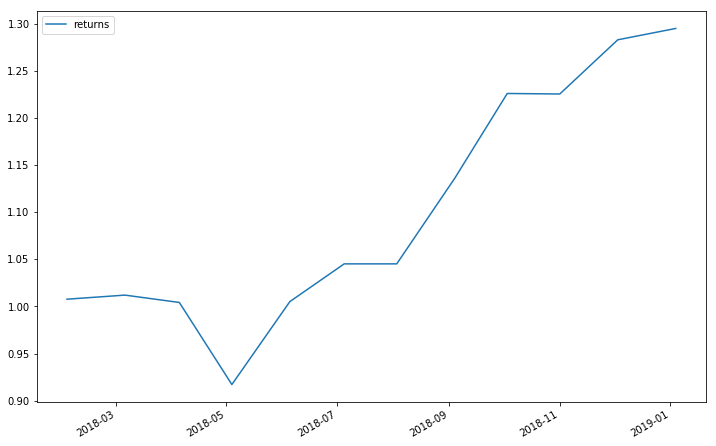

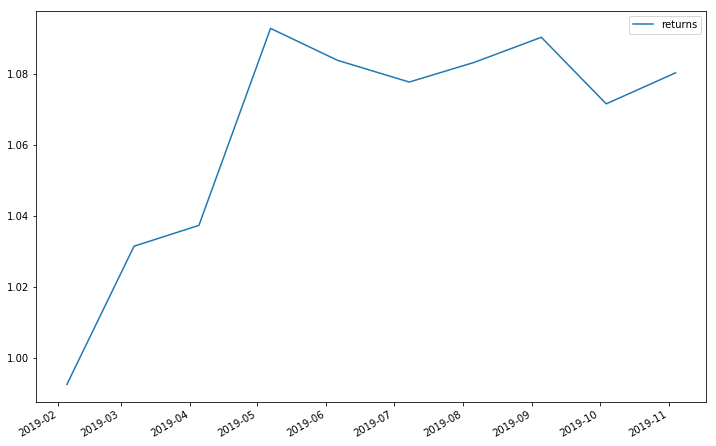

In [271]:
#MVE portfolio without elastic net shrinkage
mve_port_monthly_returns=mve(data1, factorlist, startdate='2014-12-30', deci_window=261)

# scale down to match the target portfolio
target = ew_port_monthly_returns['returns'].std()
mve_port_monthly_returns['returns'] = mve_port_monthly_returns['returns'] * target / mve_port_monthly_returns['returns'].std()
mve_port_monthly_returns1=mve_port_monthly_returns.fillna(0)
idx1=list(range(5, len(mve_port_monthly_returns1['returns']), 21))
plt.figure(0)
plt.rcParams['figure.figsize'] = (12.0,8.0)
(mve_port_monthly_returns1.iloc[idx1,]+1).cumprod().plot()
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
for i in range(1,6):
    plt.figure(i)
    idx0=idx1[(i-1)*12:i*12]
    (mve_port_monthly_returns1.iloc[idx0,]+1).cumprod().plot()

### Mean Variance efficient portforlio with Elastic net shrinkage 
### in which the best lambda is decided by cross-validation

[-0.         -0.         -0.         -0.22649883  0.         -3.2239712
 -1.48539382  0.        ]
[-0.          0.         -0.         -0.34265644  0.30093001 -3.43000745
 -2.21855119  0.        ]
[-0.          0.          0.          0.23925349  0.51004744 -3.11018686
 -1.54725622 -0.        ]
[-0.          0.          0.          0.23503772  0.56420946 -3.0805946
 -1.69777644 -0.        ]
[-0.          0.          0.          0.51556402  0.75551267 -2.05197798
 -0.80745764 -0.        ]


<Figure size 864x576 with 0 Axes>

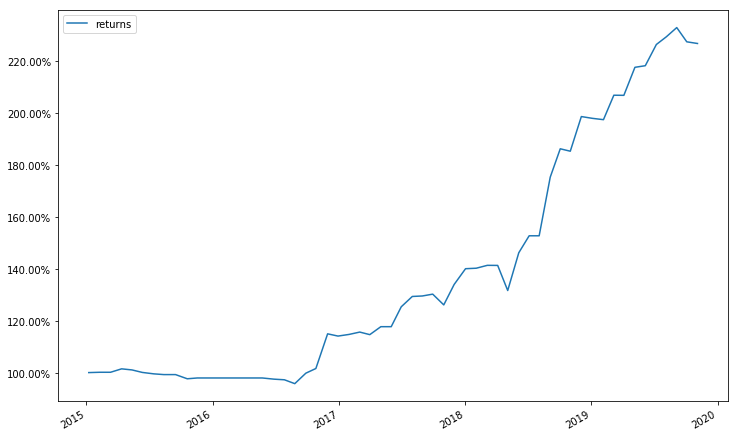

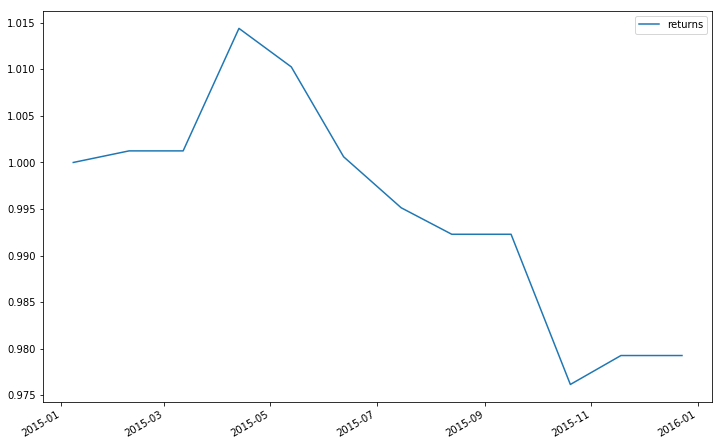

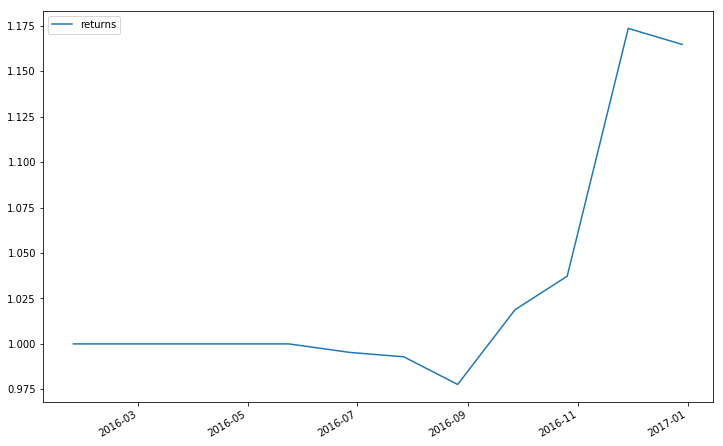

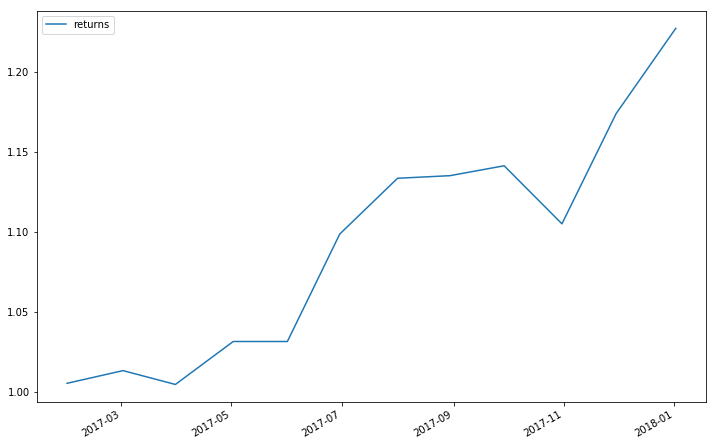

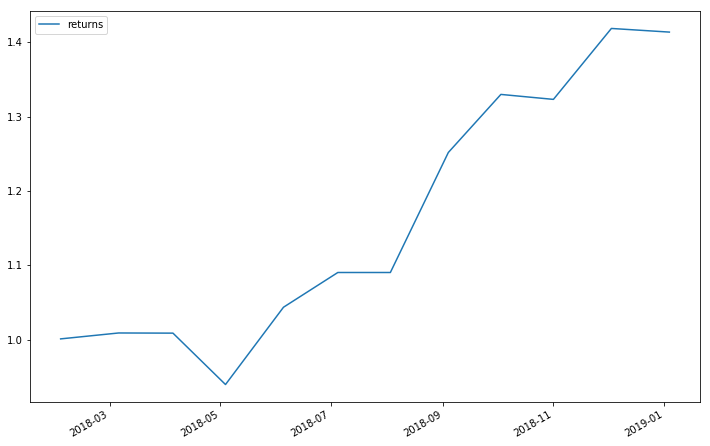

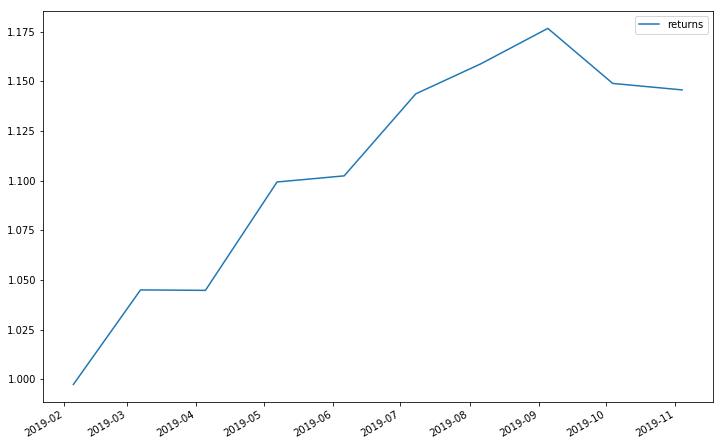

In [272]:
#MVE portfolio with elastic net shrinkage
mve_en_port_monthly_returns=mve_elasicnet(data1, factorlist, startdate='2014-12-30', deci_window=261)

# scale down to match the target portfolio
mve_en_port_monthly_returns['returns'] = mve_en_port_monthly_returns['returns'] * target / mve_en_port_monthly_returns['returns'].std()
mve_en_port_montly_returns1=mve_en_port_monthly_returns.fillna(0)
idx2=list(range(5, len(mve_en_port_monthly_returns1['returns']), 21))
plt.figure(0)
(mve_en_port_monthly_returns1.iloc[idx2,]+1).cumprod().plot()
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
for i in range(1,6):
    plt.figure(i)
    idx0=idx2[(i-1)*12:i*12]
    (mve_en_port_monthly_returns1.iloc[idx0,]+1).cumprod().plot()

In [240]:
ew_rtn_annual = ew_port_monthly_returns['returns'].mean()*12
ew_sharpe_annual =ew_port_monthly_returns['returns'].mean()/ew_port_monthly_returns['returns'].std() * math.sqrt(12)
vw_rtn_annual = vw_port_monthly_returns['returns'].mean()*12
vw_sharpe_annual =vw_port_monthly_returns['returns'].mean()/vw_port_monthly_returns['returns'].std() * math.sqrt(12)
mve_rtn_annual = mve_port_monthly_returns1['returns'].iloc[idx1,].mean()*12
mve_sharpe_annual =mve_port_monthly_returns1['returns'].iloc[idx1,].mean()/mve_port_monthly_returns1['returns'].std() * math.sqrt(12)
mve_en_rtn_annual = mve_en_port_monthly_returns1.iloc[idx2,]['returns'].mean()*12
mve_en_sharpe_annual =mve_en_port_monthly_returns1.iloc[idx2,]['returns'].mean()/mve_en_port_monthly_returns1['returns'].std() * math.sqrt(12)

### Fama French 3 Factors model to see the alpha and market beta

In [259]:
#fama french 3 factors
def famafrenchreg(port_data,factor='ff3factors'):
    if factor=='ff3factors':
        factor_data=np.array(port_data.loc[:,['Mkt-RF','SMB','HML']])
    else:
        factor_data=port_data.loc[:,factor].tolist()   

    factor_data = sm.add_constant(factor_data)
    excessrtn=(port_data['returns'].fillna(method='ffill')-port_data['RF']).tolist()
    lm=sm.OLS(excessrtn,factor_data).fit()
    alpha=lm.params[0]
    beta_mkt=lm.params[1]
    beta_smb=lm.params[2]
    beta_hml=lm.params[3]
    print (lm.summary ())
    return alpha,beta_mkt


fama=pd.DataFrame(pd.read_csv("fama.csv"))
fama['date']=fama['date'].apply(lambda x:pd.to_datetime(str(x), format='%Y%m%d'))
fama.set_index(['date'], inplace=True)
fama_ew=pd.merge(ew_port_monthly_returns,fama,how='left',left_index=True,right_index=True)
fama_vw=pd.merge(vw_port_monthly_returns,fama,how='left',left_index=True,right_index=True)
fama_mve=pd.merge(mve_port_monthly_returns1.iloc[idx1,],fama,how='left',left_index=True,right_index=True)
fama_mve_en=pd.merge(mve_en_port_monthly_returns1.iloc[idx2,],fama,how='left',left_index=True,right_index=True)

ew_alpha, ew_marketbeta=famafrenchreg(fama_ew)
vw_alpha, vw_marketbeta=famafrenchreg(fama_vw)
mve_alpha, mve_marketbeta=famafrenchreg(fama_mve)
mve_en_alpha, mve_en_marketbeta=famafrenchreg(fama_mve_en)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.4136
Date:                Thu, 10 Dec 2020   Prob (F-statistic):              0.744
Time:                        17:53:53   Log-Likelihood:                 110.50
No. Observations:                  59   AIC:                            -213.0
Df Residuals:                      55   BIC:                            -204.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.005      0.592      0.5

### Comparison of foue Portfolios
To better compare the four portfolios in a more intuitive way, the following graph shows cumulative returns during the test period of different portfolios. From 2015 to 2017, the equal-weighted and value- weighted portfolios experience more volatile movement than the two mean-variance efficient portfolios. The possible reason could be that there is no huge difference between 'winner' stocks and 'loser' stocks, and thus the rank analysis shows no obvious profitability. After 2017, the strategy begins to work well with the MVE with elastic net performing the best especially since the middle of 2018.

The worst strategy is the equal-weighted portfolio, which has 7.4% annual return and 0.56 annual Sharpe ratio. The MVE with elastic net portfolio produces 17.8% annual return and an annual Sharpe ratio of 1.35, which is very significant for a backtest strategy. It further proves that the MVE elastic net portfolio can grasp profitable opportunities and reduce risk simultaneously. More specific results of annual returns, annual Sharpe ratios, monthly alphas and monthly market betas of the four different portfolios are shown below.

In [242]:
returns_compare=pd.DataFrame({'ew':ew_port_monthly_returns['cum_returns'][:-1],
                              'vw':vw_port_monthly_returns['cum_returns'].tolist(),
                              'mve':(mve_port_monthly_returns1.iloc[idx1,]+1).cumprod()['returns'].tolist(),
                              'mve_ElasticNet':(mve_en_port_monthly_returns1.iloc[idx2,]+1).cumprod()['returns'].tolist()
                             })

statistic_compare=pd.DataFrame({'portfolio':['ew','vw','mve','mve_ElasticNet'],
                                'annual return':[ew_rtn_annual,vw_rtn_annual,mve_rtn_annual,mve_en_rtn_annual],
                                'annual sharpe ratio':[ew_sharpe_annual,vw_sharpe_annual,mve_sharpe_annual,mve_en_sharpe_annual],
                                'monthly alpha':[ew_alpha,vw_alpha,mve_alpha,mve_en_alpha],
                                'monthly market beta':[ew_marketbeta,vw_marketbeta,mve_marketbeta,mve_en_marketbeta]})

,portfolio,annual return,annual sharpe ratio,monthly alpha,monthly market beta
0,ew,0.074138,0.562029,0.002993,0.005471
1,vw,0.108019,0.626398,0.004538,-0.013169
2,mve,0.135935,1.094021,0.008583,-0.005800
3,mve_ElasticNet,0.178189,1.350815,0.011749,-0.004076


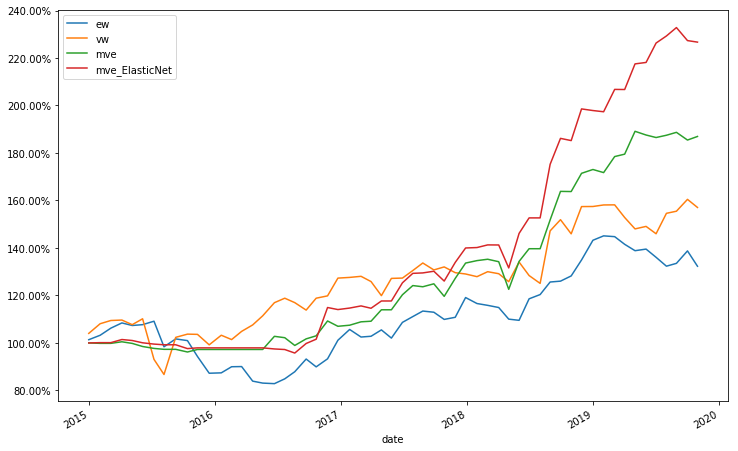

In [258]:
plt.rcParams['figure.figsize'] = (12.0,8.0)
returns_compare.plot()
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.legend()
statistic_compare

### Recommendations for Future Extensions
The portfolio comparison shows that the mean variance efficient portfolio has the best performance. However, from the graph, we can see that the cumulative returns are almost flat at the beginning of the backtest period, which may lead to problems that if I start applying this strategy in 2015 and there’s no effective return generated, we probably need to modify the model soon at the end of the year. That is why we need further extensions since most of our factors are related to market prices without any country-level macro factors, which may generate significant alpha.

Other than paying attention to the factors and different methods of portfolio construction, I can also investigate the countries selected in our model and examine performance differences between country indices during different periods. For example, if the Unites States ranks top or is selected frequently in the 'winner' quantile, I may conclude that the country is performing better than others or experiencing a positive trend in its stock market. It can also help us look from a broader horizon on the global asset allocation. Furthermore, more factors other than momentum and trading volume can be explored to discover other perspectives of the ETFs. Besides statistical variables, textual analysis or sentiment from the news can also be researched and combined with our current strategy.

In the further step, to enhance my strategy other than seeking alphas, i also need to consider the transaction cost, risk control as well as other constrains like maximum trade size and maximum position size in my strategy to optimize the weights of the long and short positions. The daily intraday monitoring on the performance of the real trading process such as the price effect, P&L, position and trade size is also needed to ensure that I am trading as planned.